In [1]:
from pvtrace import *
from scipy.interpolate import interp1d
# Some packages used by pvtrace are a little noisy
logging.getLogger('trimesh').disabled = True
logging.getLogger('shapely.geos').disabled = True
logging.getLogger('numpy').disabled = True
logging.getLogger('matplotlib').disabled = True
import functools
import numpy as np
import trimesh
import matplotlib.pyplot as plt
#%matplotlib inline

DEBUG:matplotlib.font_manager:Using fontManager instance from /home/seif/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
ab=np.loadtxt('abs.csv',delimiter=',')
em=np.loadtxt('emis.csv',delimiter=',')
lamp=np.loadtxt('Original.csv',delimiter=',')
lampcal=np.loadtxt('xenout.csv',delimiter=',')
pppt=np.loadtxt('PPPT.csv',delimiter=',')
pppt[:,1]*=14.0

f2 = interp1d(lamp[:,0], lamp[:,1], kind='cubic')

lamp2=np.zeros((len(ab[:,0]),2))
lamp2[:,0]=np.copy(ab[:,0])
lamp2[:,1]=f2(ab[:,0])

559.2278638786181

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manag

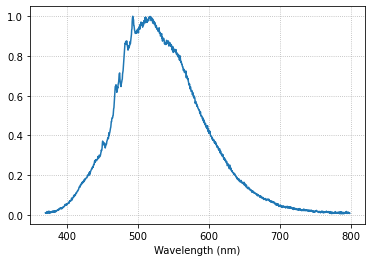

In [3]:
x = lampcal[:,0]
y = lampcal[:,1]
plt.plot(x, y)
plt.xlabel('Wavelength (nm)')
plt.grid(linestyle='dotted')
dist = Distribution(x, y)
dist.sample(np.random.uniform())

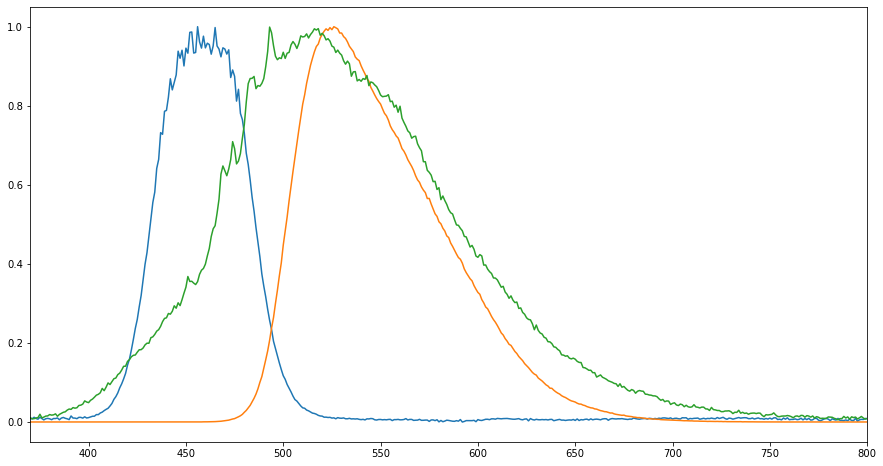

In [4]:
plt.figure(figsize=(15,8))

plt.plot(ab[:,0],ab[:,1])

plt.plot(em[:,0],em[:,1])
plt.plot(lamp2[:,0],lamp2[:,1])
plt.xlim(370,800)
plt.show()

In [5]:
ab[:,1]*=36.9 #value for cm-1, see the README for details of where this value came from
ab

array([[3.7000000e+02, 3.2841000e-01],
       [3.7100000e+02, 3.0516300e-01],
       [3.7200000e+02, 4.4575200e-01],
       [3.7300000e+02, 3.2545800e-01],
       [3.7400000e+02, 2.6604900e-01],
       [3.7500000e+02, 4.4538300e-01],
       [3.7600000e+02, 3.2398200e-01],
       [3.7700000e+02, 1.9889100e-01],
       [3.7800000e+02, 3.0848400e-01],
       [3.7900000e+02, 3.4021800e-01],
       [3.8000000e+02, 3.0073500e-01],
       [3.8100000e+02, 2.1807900e-01],
       [3.8200000e+02, 3.2914800e-01],
       [3.8300000e+02, 3.2435100e-01],
       [3.8400000e+02, 3.8043900e-01],
       [3.8500000e+02, 2.1143700e-01],
       [3.8600000e+02, 3.6752400e-01],
       [3.8700000e+02, 4.2730200e-01],
       [3.8800000e+02, 3.4907400e-01],
       [3.8900000e+02, 3.0184200e-01],
       [3.9000000e+02, 2.2582800e-01],
       [3.9100000e+02, 5.6530800e-01],
       [3.9200000e+02, 3.7158300e-01],
       [3.9300000e+02, 3.6863100e-01],
       [3.9400000e+02, 3.1512600e-01],
       [3.9500000e+02, 4.

In [7]:
class PartialEndSurfaceMirror(FresnelSurfaceDelegate):

    def reflectivity(self, surface, ray, geometry, container, adjacent):
        """ Return the reflectivity of the part of the surface hit by the ray.
        
            Parameters
            ----------
            surface: Surface
                The surface object belonging to the material.
            ray: Ray
                The ray hitting the surface in the local coordinate system of the `geometry` object.
            geometry: Geometry
                The object being hit (e.g. Sphere, Box, Cylinder, Mesh etc.)
            container: Node
                The node containing the ray.
            adjacent: Node
                The node that will contain the ray if the ray is transmitted.
        """
        # Get the surface normal to determine which surface has been hit.
        normal = geometry.normal(ray.position)
        
        # Normal are outward facing
        TOP_SURFACE = (0, -1, 0)
        
        # If a ray hits the top surface where x > 0 and y > 0 reflection
        # set the reflectivity to 1.
        if np.allclose(normal, TOP_SURFACE):
            y = ray.position[1]
            if y < 0:
                return 1.0
        
        # Otherwise return the Frensel reflection probability.
        return super(PartialEndSurfaceMirror, self).reflectivity(surface, ray, geometry, container, adjacent)

In [6]:
opaque = Material(
    refractive_index=1.83,
    #surface=Surface(delegate=PartialEndSurfaceMirror()), #Uncomment for mirrored end
    components=[
        Luminophore(
            coefficient=ab,
            emission=em,
            quantum_yield=0.88,
            phase_function=isotropic  # can also have phase functions
        )
    ]
)

In [8]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Material(refractive_index=1)
    )
)
mesh = Node(
    name="lc",
    geometry=Mesh(
        trimesh=trimesh.load('Fishtail.STL'),material=opaque #change STL to desired size
    ),
    
    parent=world
)

sphere = Node(
    name="sphere (glass)",
    geometry=Sphere(
        radius=1.0,
        material=Material(
            refractive_index=1.62,
            components=[
                Absorber(
                coefficient=pppt
                )
            ]
        ),
    ),
    parent=world
)

sphere.location = (0, 4.5, 1)
mesh.translate((0, 0.5, 1))
mesh.rotate(np.pi/2,(1,0,0))
mesh.rotate(-np.pi/2,(0,0,1))
#mesh.rotate(-np.pi,(0,0,1)) #for goose
#mesh.translate((0, 0, 5)) #for goose
#sphere.location = (0, 4.5, 12)# for goose

Node(lc)

In [9]:
scene = Scene(world)
def newwav():
    return 450.0
light = Light(position=functools.partial(rectangular_mask, 0.05, 2),
              direction=functools.partial(cone, np.pi/8),
              wavelength=newwav)

vis = MeshcatRenderer(wireframe=True)
vis.render(scene)
for ray in light.emit(100):
    steps = photon_tracer.follow(scene, ray)
    path, decisions = zip(*steps)
    vis.add_ray_path(path)
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [ ]:
import csv

a_list = []
for ray in light.emit(100000):
    steps = photon_tracer.follow(scene, ray)
    a_list.append(steps)
    path, decisions = zip(*steps)

with open("output_water_withPLQY_originalmesh_100000.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile)
     wr.writerows(a_list)

In [ ]:
import csv

a_list = []
for ray in light.emit(1000):
    steps = photon_tracer.follow(scene, ray)
    a_list.append(steps)
    path, decisions = zip(*steps)

with open("output_air_withPLQY_originalmesh_1000.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile)
     wr.writerows(a_list)

In [9]:
import csv

a_list = []
for ray in light.emit(10000):
    steps = photon_tracer.follow(scene, ray)
    a_list.append(steps)
    path, decisions = zip(*steps)

with open("output_air_withPLQY_optimummesh_10000.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile)
     wr.writerows(a_list)

In [ ]:
import csv

a_list = []
for ray in light.emit(10000):
    steps = photon_tracer.follow(scene, ray)
    a_list.append(steps)
    path, decisions = zip(*steps)

with open("output_air_withPLQY_mirrorfishtail_10000.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile)
     wr.writerows(a_list)